In [205]:
import numpy as np
from scipy.stats import mode
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler

### Загрузка данных. Удаление ненужного столбца.

In [2]:
df = pd.read_csv('data/train.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment
0,96218,2012-06-19,2012-06-21,182,38,red,17,109.9,21163,Mrs,1967-03-25,Baden-Wuerttemberg,2012-06-19,1
1,96219,2012-06-19,2012-06-21,557,38,red,1,129.9,21163,Mrs,1967-03-25,Baden-Wuerttemberg,2012-06-19,1
2,96220,2012-06-19,2012-06-21,90,38,red,24,69.9,21163,Mrs,1967-03-25,Baden-Wuerttemberg,2012-06-19,0
3,96221,2012-06-19,2012-06-21,1,38,red,1,119.9,21163,Mrs,1967-03-25,Baden-Wuerttemberg,2012-06-19,1
4,96222,2012-06-19,2012-06-21,1,37+,red,1,119.9,21163,Mrs,1967-03-25,Baden-Wuerttemberg,2012-06-19,1


### Поиск пропусков в данных.

In [47]:
has_null = df.isna().any()
is_null = df.isna().sum()
for col in df.columns:
    print(f"{col:<15} {'True ' if has_null[col] else 'False'}  {is_null[col]}")

orderItemID     False  0
orderDate       False  0
deliveryDate    False  0
itemID          False  0
size            False  0
color           False  0
manufacturerID  False  0
price           False  0
customerID      False  0
salutation      False  0
dateOfBirth     False  0
state           False  0
creationDate    False  0
returnShipment  False  0


In [38]:
# Приведение столбцов с датами, содержащих пропуски, к дате
df['orderDate'] = pd.to_datetime(df['orderDate'], format='%Y-%m-%d', errors='coerce')
df['deliveryDate'] = pd.to_datetime(df['deliveryDate'], format='%Y-%m-%d', errors='coerce')
df['dateOfBirth'] = pd.to_datetime(df['dateOfBirth'], format='%Y-%m-%d', errors='coerce')
df['creationDate'] = pd.to_datetime(df['creationDate'], format='%Y-%m-%d', errors='coerce')
# Вставка моды в пропуски цвета
df['color'] = df['color'].fillna(df['color'].mode()[0])

In [46]:
# Убираем оставшиеся пропуски
df['deliveryDate'] = df['deliveryDate'].fillna(df['deliveryDate'].median())
df['dateOfBirth'] = df['dateOfBirth'].fillna(df['dateOfBirth'].median())

### Хуярим ебучие графики в очередной раз

In [202]:
def scatters(df, col_name, t_name):
    tmp = df.groupby(col_name)[t_name].sum().to_dict()
    tmp_sorted = dict(sorted(tmp.items(), key=lambda item: item[1]))
    sns.scatterplot(tmp_sorted)
    del tmp, tmp_sorted

def scatters_total(df, col_name, t_name):
    tmp = df.groupby(col_name)[t_name].count().to_dict()
    tmp_sorted = dict(sorted(tmp.items(), key=lambda item: item[1]))
    sns.scatterplot(tmp_sorted)
    del tmp, tmp_sorted

def cats(df, col_name, target):
    sns.catplot(data=df, x=target, y=col_name, kind='boxen')

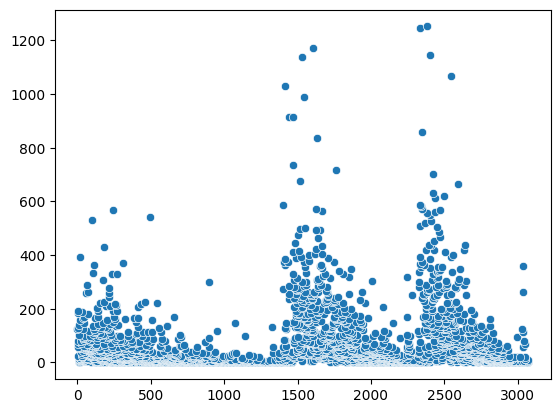

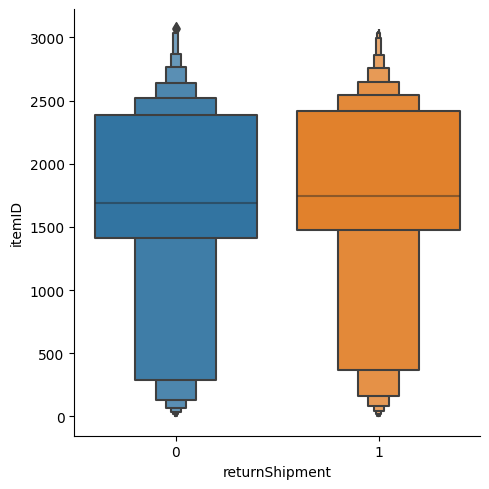

In [163]:
scatters(df, 'itemID', 'returnShipment')
cats(df, 'itemID', 'returnShipment')

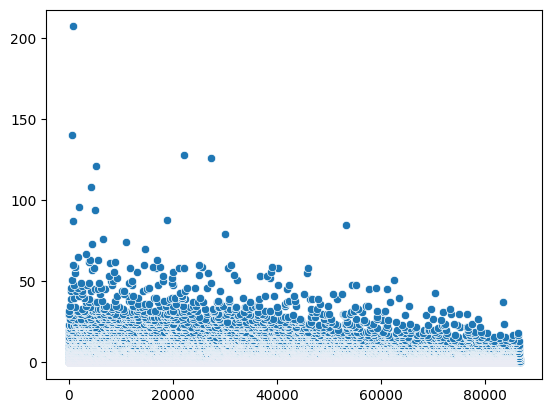

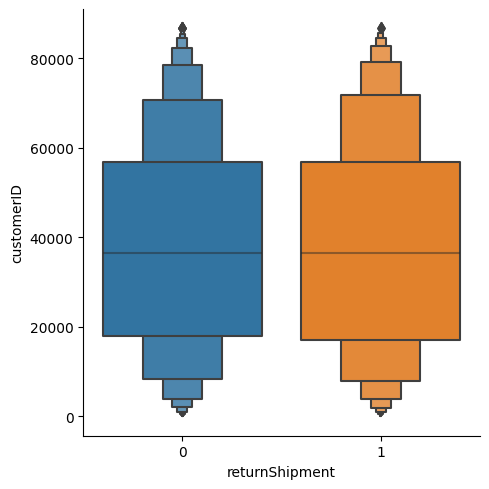

In [164]:
scatters(df, 'customerID', 'returnShipment')
cats(df, 'customerID', 'returnShipment')

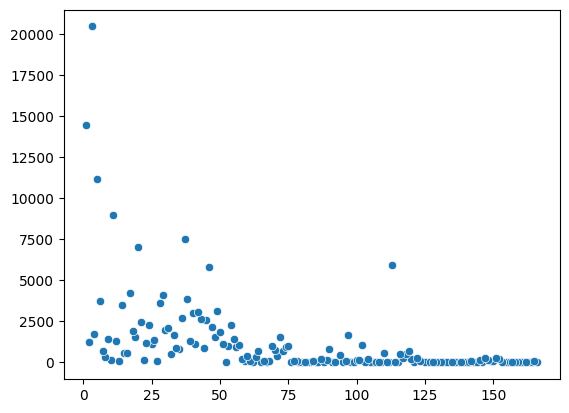

In [253]:
scatters(df, 'manufacturerID', 'returnShipment')

#### PCA как и FA посылают меня нахуй

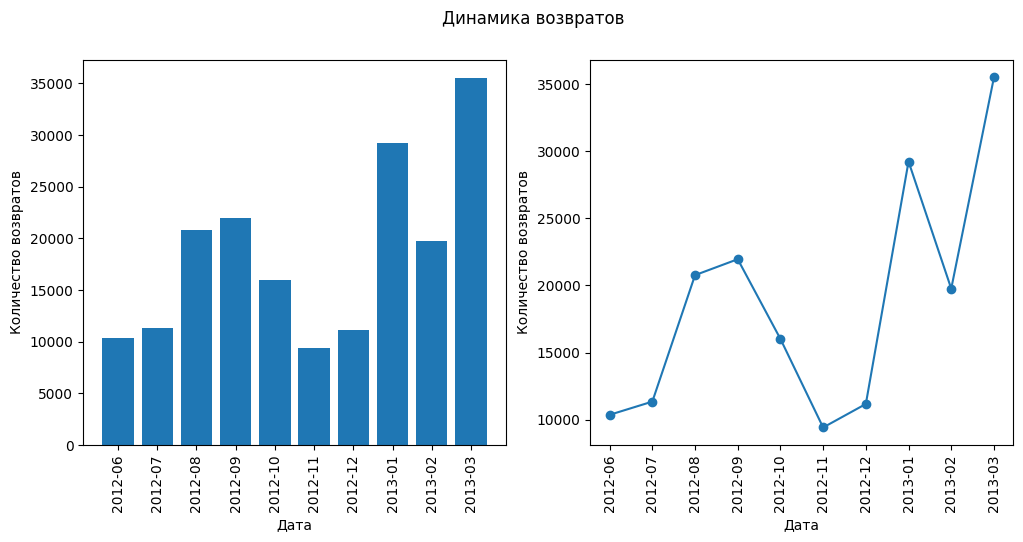

In [264]:
# По годам и месяцам как всё живёт
date_stat = df
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
fig.suptitle('Динамика возвратов')
date_stat['year'] = date_stat['orderDate'].dt.year
date_stat['month'] = date_stat['orderDate'].dt.month
stats_df = date_stat.groupby(['year', 'month'])['returnShipment'].sum()
index_tuples = stats_df.index.to_list()
labels = [f"{year}-{month:02d}" for year, month in index_tuples]
axs[0].bar(x=range(len(stats_df)), height=stats_df.values)
axs[0].set_xticks(ticks=range(len(labels)), labels=labels, rotation=90)
axs[0].set_xlabel('Дата')
axs[0].set_ylabel('Количество возвратов')
axs[1].plot(stats_df.values)
axs[1].scatter(x=range(len(stats_df)) ,y=stats_df.values)
axs[1].set_xticks(ticks=range(len(labels)), labels=labels, rotation=90)
axs[1].set_xlabel('Дата')
axs[1].set_ylabel('Количество возвратов')
plt.show()
del date_stat, stats_df, index_tuples, labels

### Сравнение распределения на обучающей и тестовой выборке

In [84]:
test = pd.read_csv('data/test.csv')
test.drop('Unnamed: 0', axis=1, inplace=True)

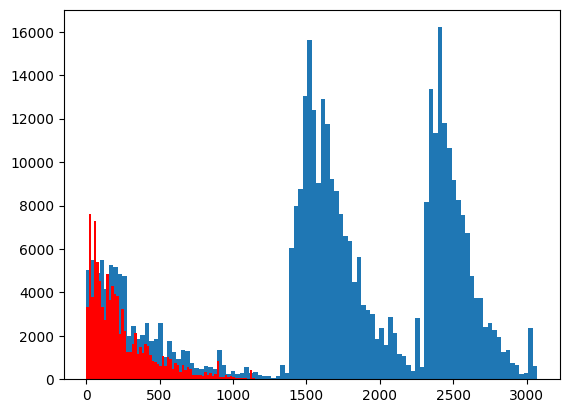

In [106]:
plt.hist(df['itemID'], bins=100)
plt.hist(test['itemID'], color='red', bins=80);

Меньше половины товаров есть на тесте, а ещё вроде бы 2 трети покупателей нахуй пропали из теста, но это нужно будет проверить.